In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
RANDOM_SEED = 42
%matplotlib inline

In [2]:
dataset_path = './Dataset/'
person_folders = os.listdir(dataset_path)
print(person_folders)

df = pd.DataFrame()
df_list = []

for i in range(len(person_folders)):
    person_folder = person_folders[i]
    csv_file_path = dataset_path + person_folder + '/'
    csv_files = os.listdir(csv_file_path)

    for j in range(len(csv_files)):
        csv_file = csv_files[j]
        #print(csv_file)

        data_frame = pd.read_csv(csv_file_path + '/' + csv_file, index_col=None, header=None)
        df_list.append(data_frame)

df = pd.concat(df_list, axis = 0, sort= True, ignore_index = True)
df.columns = ['Timestamp', 'Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'Label', 'Activity']

['P1', 'P2', 'P3', 'P4', 'P5', 'P6']


In [3]:
print(df.count())
df.head()

Timestamp    105881
Ax           105881
Ay           105881
Az           105881
Gx           105881
Gy           105881
Gz           105881
Label        105881
Activity     105881
dtype: int64


,Timestamp,Ax,Ay,Az,Gx,Gy,Gz,Label,Activity
0,1.564040e+12,0.499756,0.798584,-0.313110,-16.768293,-10.091463,11.189024,4,Eating
1,1.564040e+12,0.497314,0.826172,-0.312622,-6.981707,-11.310976,10.731707,4,Eating
2,1.564040e+12,0.495605,0.825562,-0.313477,-5.823171,-11.402439,3.993902,4,Eating
3,1.564040e+12,0.493408,0.823242,-0.314697,-5.091463,-11.067073,6.890244,4,Eating
4,1.564040e+12,0.495605,0.819336,-0.315552,-4.115854,-11.189024,16.890244,4,Eating


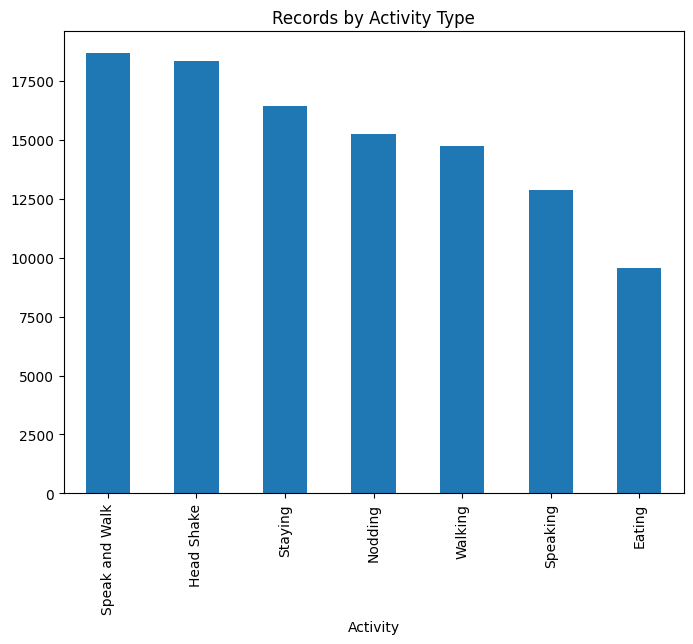

In [4]:
df['Activity'].value_counts().plot(kind='bar', title='Records by Activity Type', figsize=(8, 6),align='center');

In [5]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'

df['Ax'] = df['Ax'] / df['Ax'].max()
df['Ay'] = df['Ay'] / df['Ay'].max()
df['Az'] = df['Az'] / df['Az'].max()

df['Gx'] = df['Gx'] / df['Gx'].max()
df['Gy'] = df['Gy'] / df['Gy'].max()
df['Gz'] = df['Gz'] / df['Gz'].max()

# Round numbers
df = df.round({'Ax': 5, 'Ay': 5, 'Az': 5, 'Gx': 5, 'Gy': 5, 'Gz': 5})

In [7]:
import pandas as pd

N_TIME_STEPS = 80
N_FEATURES = 6
step = 20
segments = []
labels = []

for i in range(0, len(df) - N_TIME_STEPS, step):
    Ax = df['Ax'].values[i: i + N_TIME_STEPS]
    Ay = df['Ay'].values[i: i + N_TIME_STEPS]
    Az = df['Az'].values[i: i + N_TIME_STEPS]
    
    Gx = df['Gx'].values[i: i + N_TIME_STEPS]
    Gy = df['Gy'].values[i: i + N_TIME_STEPS]
    Gz = df['Gz'].values[i: i + N_TIME_STEPS]
    
    label = df['Activity'][i: i + N_TIME_STEPS].mode()[0]
    segments.append([Ax, Ay, Az, Gx, Gy, Gz])
    labels.append(label)


In [8]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=48)

In [11]:
print('X_train : ', X_train.shape)
print('X_test : ', X_test.shape)

X_train :  (4232, 80, 6)
X_test :  (1059, 80, 6)


In [15]:
print(y_train.shape)

(4232, 7)


In [26]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


segments_train = np.array(X_train)  # Shape: (num_samples, 6, 80)
labels_train = np.array(y_train)  # Shape: (num_samples,)
segments_train = segments_train.transpose(0, 2, 1)
# Convert to PyTorch tensors

segments_test = np.array(X_test)  # Shape: (num_samples, 6, 80)
labels_test = np.array(y_test)  # Shape: (num_samples,)
segments_test = segments_test.transpose(0, 2, 1)

segments_train = torch.tensor(segments_train, dtype=torch.float32)
labels_train = torch.tensor(labels_train, dtype=torch.float32)
segments_test = torch.tensor(segments_test, dtype=torch.float32)
labels_test = torch.tensor(labels_test, dtype=torch.float32)

In [22]:
print(type(labels_train))

<class 'torch.Tensor'>


In [27]:
class SensorDataset(Dataset):
    def __init__(self, segments, labels):
        self.segments = segments
        self.labels = labels

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx], self.labels[idx]

# Create dataset and dataloader
dataset_train = SensorDataset(segments_train, labels_train)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataset_test = SensorDataset(segments_test, labels_test)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True)


In [36]:
import torch.nn as nn
import torch.nn.functional as F

class CNN1D(nn.Module):
    def __init__(self, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=6, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*10, 128)  # Adjust this based on the output size from conv layers
        self.fc2 = nn.Linear(128, num_classes)
        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Example usage:
num_classes = len(np.unique(labels))  # Number of activity classes
model = CNN1D(7)




Epoch 1/20, Train Loss: 1.3775782782332342, Val Loss: 0.685004291288993
Epoch 2/20, Train Loss: 0.6690019541665128, Val Loss: 0.44041814401691015
Epoch 3/20, Train Loss: 0.5574842385555568, Val Loss: 0.41982152225340114
Epoch 4/20, Train Loss: 0.49597260804104626, Val Loss: 0.3613953348797034
Epoch 5/20, Train Loss: 0.47545630277547624, Val Loss: 0.3878275654004777
Epoch 6/20, Train Loss: 0.4285762175581509, Val Loss: 0.33018295773688483
Epoch 7/20, Train Loss: 0.4036551203046526, Val Loss: 0.31599201831747503
Epoch 8/20, Train Loss: 0.38718892600303306, Val Loss: 0.32073382156736713
Epoch 9/20, Train Loss: 0.3708861713346682, Val Loss: 0.3268027515647084
Epoch 10/20, Train Loss: 0.3549119082272501, Val Loss: 0.3360798571477918
Epoch 11/20, Train Loss: 0.3413793018325827, Val Loss: 0.27750079969272895
Epoch 12/20, Train Loss: 0.33554357127811674, Val Loss: 0.28046173758476095
Epoch 13/20, Train Loss: 0.3187133065964046, Val Loss: 0.2898675193462302
Epoch 14/20, Train Loss: 0.3101301471

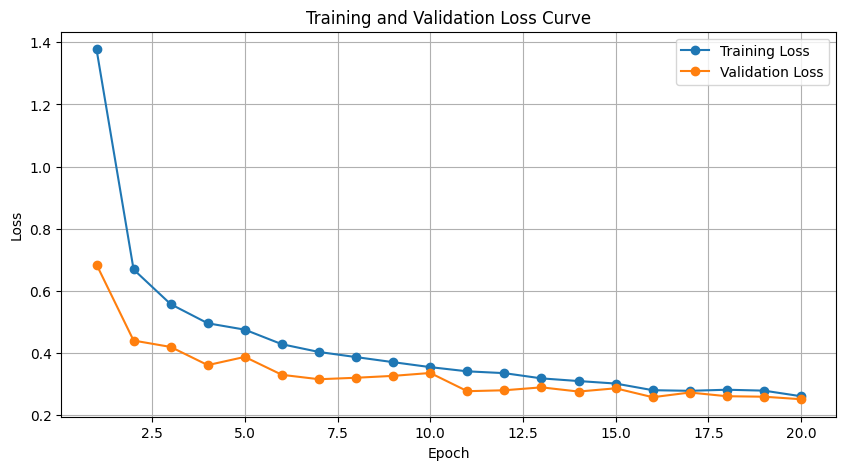

In [37]:
# Loss function and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    for inputs, one_hot_labels in train_loader:
        optimizer.zero_grad()
        
        # Convert one-hot encoded labels to class indices
        labels = torch.argmax(one_hot_labels, dim=1)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    
    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, one_hot_labels in test_loader:
            labels = torch.argmax(one_hot_labels, dim=1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    
    epoch_val_loss = running_val_loss / len(test_loader)
    val_losses.append(epoch_val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss}, Val Loss: {epoch_val_loss}')

print('Finished Training')

# Plot the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

print("testing accuracy: ")
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        labels = torch.argmax(labels, dim=1)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total}%')

testing accuracy: 
Accuracy: 90.46270066100094%


In [40]:
print(np.unique(df['Activity']))

['Eating' 'Head Shake' 'Nodding' 'Speak and Walk' 'Speaking' 'Staying'
 'Walking']


[[ 78   0   0   0   7   7   4]
 [  1 185   0   2   0   0   1]
 [  0   2 157   0   0   0   0]
 [  0   0   0 163   5   0  16]
 [ 21   0   1   5  81   1   2]
 [  0   0   0   0   4 161   1]
 [  1   1   0  18   1   0 133]]


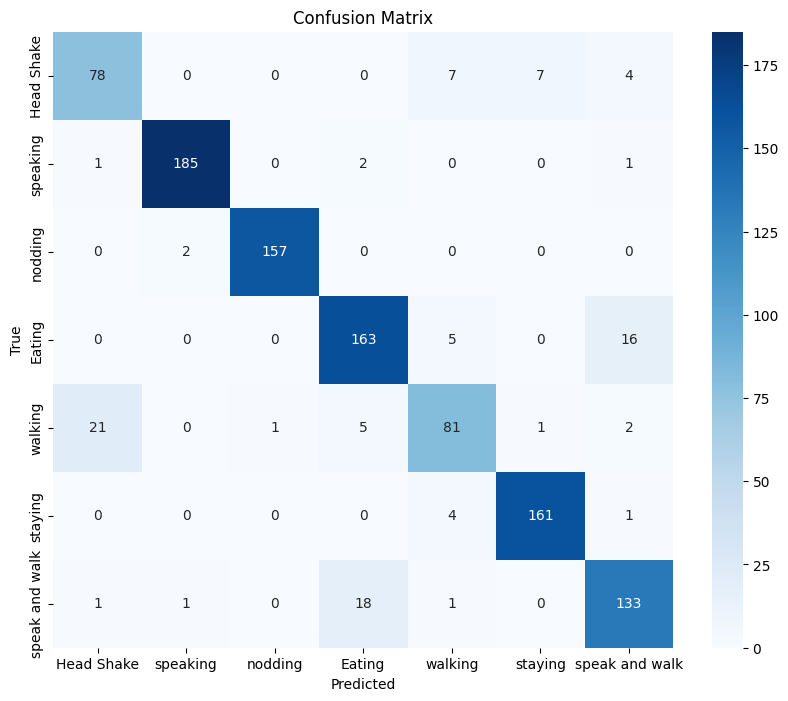

In [41]:
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have a test dataloader
model.eval()  # Set the model to evaluation mode

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, one_hot_labels in test_loader:
        outputs = model(inputs)
        
        # Convert one-hot encoded labels to class indices
        labels = torch.argmax(one_hot_labels, dim=1)
        
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(probabilities, 1)
        
        # Collect all labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print(conf_matrix)

# Define your activity labels here
activity_labels = ['Head Shake', 'speaking', 'nodding', 'Eating', 'walking', 'staying', 'speak and walk']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=activity_labels, yticklabels=activity_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [42]:
def model_size_in_mb(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    param_size = 4  # Size of a float32 parameter in bytes
    total_size_in_bytes = total_params * param_size
    total_size_in_mb = total_size_in_bytes / (1024 ** 2)  # Convert bytes to megabytes
    return total_size_in_mb

model_size = model_size_in_mb(model)
print(f'Model size: {model_size:.2f} MB')

Model size: 0.35 MB


!D CNN and LSTM

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNNLSTM(nn.Module):
    def __init__(self, num_classes, input_size=6, cnn_out_channels=64, lstm_hidden_size=128, lstm_num_layers=1):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=cnn_out_channels, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=cnn_out_channels, hidden_size=lstm_hidden_size, num_layers=lstm_num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(lstm_hidden_size, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # 1D CNN
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # LSTM expects input shape (batch, seq_len, input_size)
        x = x.permute(0, 2, 1)  # (batch, channels, seq_len) -> (batch, seq_len, channels)
        
        # LSTM
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the last output of the sequence
        
        # Fully connected layer
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Example usage:
num_classes = 7  # Number of activity classes
model1 = CNNLSTM(num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)




Epoch 1/20, Train Loss: 1.5716904764784907, Val Loss: 1.0180059338317198
Epoch 2/20, Train Loss: 0.8805115104169774, Val Loss: 0.7866708723937764
Epoch 3/20, Train Loss: 0.682902366371083, Val Loss: 0.6236601112519994
Epoch 4/20, Train Loss: 0.5690901430701851, Val Loss: 0.5492845125058118
Epoch 5/20, Train Loss: 0.5076088789934502, Val Loss: 0.4546850770711899
Epoch 6/20, Train Loss: 0.46000940683192776, Val Loss: 0.38809310644865036
Epoch 7/20, Train Loss: 0.4106903487354293, Val Loss: 0.35573070803109336
Epoch 8/20, Train Loss: 0.3863600768653074, Val Loss: 0.3346451820586534
Epoch 9/20, Train Loss: 0.35225165164784383, Val Loss: 0.3296459178056787
Epoch 10/20, Train Loss: 0.322629575610609, Val Loss: 0.34149211754693704
Epoch 11/20, Train Loss: 0.31476229493667307, Val Loss: 0.33978143958922696
Epoch 12/20, Train Loss: 0.31358353082174645, Val Loss: 0.3259784939205822
Epoch 13/20, Train Loss: 0.2884863454820518, Val Loss: 0.3333657784935306
Epoch 14/20, Train Loss: 0.26730854365330

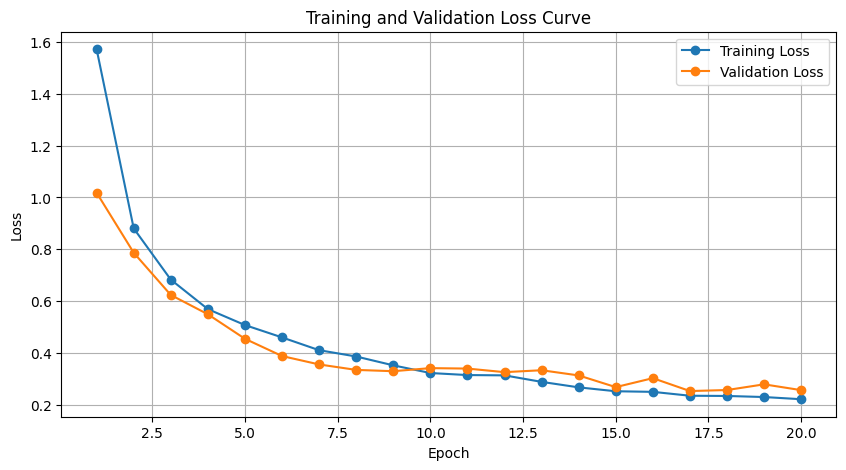

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Example dataloaders, replace these with your actual dataloaders
train_dataloader = train_loader
val_dataloader = test_loader

# Training loop with validation
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model1.train()  # Set model to training mode
    running_train_loss = 0.0
    for inputs, one_hot_labels in train_dataloader:
        optimizer.zero_grad()
        
        # Convert one-hot encoded labels to class indices
        labels = torch.argmax(one_hot_labels, dim=1)
        
        outputs = model1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    
    epoch_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(epoch_train_loss)
    
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, one_hot_labels in val_dataloader:
            labels = torch.argmax(one_hot_labels, dim=1)
            outputs = model1(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    
    epoch_val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(epoch_val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss}, Val Loss: {epoch_val_loss}')

print('Finished Training')

# Plot the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


In [51]:
# Example test dataloader, replace with your actual test dataloader
test_dataloader = val_dataloader

# Set model to evaluation mode
model1.eval()

# Lists to store true labels and predictions
true_labels = []
predictions = []

# Disable gradient computation for testing
with torch.no_grad():
    for inputs, one_hot_labels in test_dataloader:
        # Convert one-hot encoded labels to class indices
        labels = torch.argmax(one_hot_labels, dim=1)
        
        # Store true labels
        true_labels.extend(labels.cpu().numpy())
        
        # Make predictions
        outputs = model1(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Store predictions
        predictions.extend(preds.cpu().numpy())

# Convert true labels and predictions to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Calculate accuracy
accuracy = np.sum(true_labels == predictions) / len(true_labels) * 100
print(f'Accuracy: {accuracy:.2f}%')


Accuracy: 90.93%


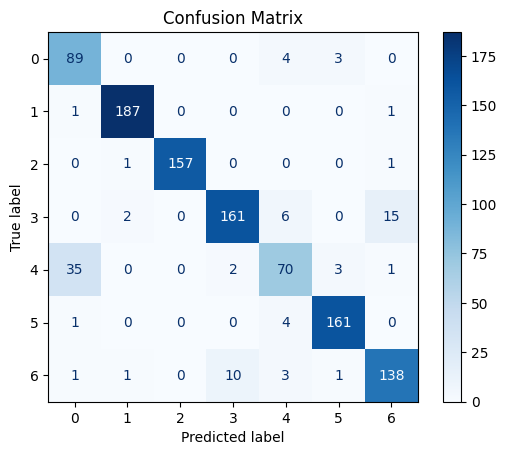

In [49]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Set model to evaluation mode
model1.eval()

# Lists to store true labels and predictions
true_labels = []
predictions = []

# Disable gradient computation for testing
with torch.no_grad():
    for inputs, one_hot_labels in val_dataloader:
        # Convert one-hot encoded labels to class indices
        labels = torch.argmax(one_hot_labels, dim=1)
        
        # Store true labels
        true_labels.extend(labels.cpu().numpy())
        
        # Make predictions
        outputs = model1(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Store predictions
        predictions.extend(preds.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [50]:
model_size = model_size_in_mb(model1)
print(f'Model size: {model_size:.2f} MB')

Model size: 0.41 MB
